In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '../src')

In [3]:
import torch
import torch.nn as nn
import torch.distributions as D
from torch.distributions.kl import kl_divergence
from torchvision import transforms as T

from tqdm.autonotebook import tqdm
from torchsummaryX import summary

from model import Generator
from space_modules import SceneEncoder
from data_utils import ImageFilelistMultiscale, show_batch

torch.set_printoptions(precision=5, linewidth=180)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
dataset = ImageFilelistMultiscale('/storage1/datasets/CLEVR_v1.0/images/train/', '*.png', resolutions=((64,64), (128, 128)))
# subset = torch.utils.data.Subset(dataset, list(range(1024)))

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    pin_memory=True,
)
batch64, batch128 = next(iter(loader))

In [8]:
scene_encoder = SceneEncoder().to(device)
summary(scene_encoder, batch128.to(device))

                                                        Kernel Shape  \
Layer                                                                  
0_img_encoder.conv_layers.0.Conv2d_0                   [3, 16, 4, 4]   
1_img_encoder.conv_layers.0.GroupNorm_1                         [16]   
2_img_encoder.conv_layers.0.CELU_2                                 -   
3_img_encoder.conv_layers.1.Conv2d_0                  [16, 32, 4, 4]   
4_img_encoder.conv_layers.1.GroupNorm_1                         [32]   
5_img_encoder.conv_layers.1.CELU_2                                 -   
6_img_encoder.conv_layers.2.Conv2d_0                  [32, 64, 4, 4]   
7_img_encoder.conv_layers.2.GroupNorm_1                         [64]   
8_img_encoder.conv_layers.2.CELU_2                                 -   
9_img_encoder.conv_layers.3.Conv2d_0                 [64, 128, 3, 3]   
10_img_encoder.conv_layers.3.GroupNorm_1                       [128]   
11_img_encoder.conv_layers.3.CELU_2                             

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_img_encoder.conv_layers.0.Conv2d_0,"[3, 16, 4, 4]","[4, 16, 64, 64]",784.0,3145728.0
1_img_encoder.conv_layers.0.GroupNorm_1,[16],"[4, 16, 64, 64]",32.0,16.0
2_img_encoder.conv_layers.0.CELU_2,-,"[4, 16, 64, 64]",NaN,NaN
3_img_encoder.conv_layers.1.Conv2d_0,"[16, 32, 4, 4]","[4, 32, 32, 32]",8224.0,8388608.0
4_img_encoder.conv_layers.1.GroupNorm_1,[32],"[4, 32, 32, 32]",64.0,32.0
5_img_encoder.conv_layers.1.CELU_2,-,"[4, 32, 32, 32]",NaN,NaN
6_img_encoder.conv_layers.2.Conv2d_0,"[32, 64, 4, 4]","[4, 64, 16, 16]",32832.0,8388608.0
7_img_encoder.conv_layers.2.GroupNorm_1,[64],"[4, 64, 16, 16]",128.0,64.0
8_img_encoder.conv_layers.2.CELU_2,-,"[4, 64, 16, 16]",NaN,NaN


In [9]:
encoded_scene = scene_encoder(batch128.to(device))
print(encoded_scene.keys())
z_bg = encoded_scene['bg_feats']
print('Background features:', z_bg.size())
view_in_bg = encoded_scene['bg_transform_params']
print('Background transform params:', view_in_bg.size())
z_fg = encoded_scene['valid_img_feats']
print('Foreground features:', z_fg.size())
view_in_fg = encoded_scene['fg_transform_params']
print('Foreground transform params:', view_in_fg.size())

dict_keys(['img_feats', 'bg_feats', 'bg_transform_params', 'glimpses_info', 'obj_pres', 'valid_img_feats', 'valid_scale', 'valid_center', 'fg_transform_params'])
Background features: torch.Size([4, 64])
Background transform params: torch.Size([4, 9])
Foreground features: torch.Size([4, 138, 128])
Foreground transform params: torch.Size([4, 138, 9])


In [10]:
generator = Generator(z_dim_bg=64, z_dim_fg=128, use_learnable_proj=False, use_inverse_transform=False).to(device)

In [11]:
generated = generator(z_bg=z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)

/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


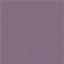

In [13]:
T.functional.to_pil_image(generated[0].cpu())

In [14]:
summary(generator, z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)

                                                         Kernel Shape  \
Layer                                                                   
0_bg_generator.adain0.Linear_z_proj                         [64, 512]   
1_bg_generator.adain0.ReLU_relu                                     -   
2_bg_generator.adain0.InstanceNorm3d_ins_norm                       -   
3_bg_generator.LeakyReLU_lrelu                                      -   
4_bg_generator.deconvs.ConvTranspose3d_0          [128, 256, 3, 3, 3]   
5_bg_generator.adains.0.Linear_z_proj                       [64, 256]   
6_bg_generator.adains.0.ReLU_relu                                   -   
7_bg_generator.adains.0.InstanceNorm3d_ins_norm                     -   
8_bg_generator.LeakyReLU_lrelu                                      -   
9_bg_generator.deconvs.ConvTranspose3d_1           [64, 128, 3, 3, 3]   
10_bg_generator.adains.1.Linear_z_proj                      [64, 128]   
11_bg_generator.adains.1.ReLU_relu                 

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_bg_generator.adain0.Linear_z_proj,"[64, 512]","[4, 512]",33280.0,32768.0
1_bg_generator.adain0.ReLU_relu,-,"[4, 512]",NaN,NaN
2_bg_generator.adain0.InstanceNorm3d_ins_norm,-,"[4, 256, 4, 4, 4]",NaN,NaN
3_bg_generator.LeakyReLU_lrelu,-,"[4, 256, 4, 4, 4]",NaN,NaN
4_bg_generator.deconvs.ConvTranspose3d_0,"[128, 256, 3, 3, 3]","[4, 128, 8, 8, 8]",884864.0,452984832.0
5_bg_generator.adains.0.Linear_z_proj,"[64, 256]","[4, 256]",16640.0,16384.0
6_bg_generator.adains.0.ReLU_relu,-,"[4, 256]",NaN,NaN
7_bg_generator.adains.0.InstanceNorm3d_ins_norm,-,"[4, 128, 8, 8, 8]",NaN,NaN
8_bg_generator.LeakyReLU_lrelu,-,"[4, 128, 8, 8, 8]",NaN,NaN


# Overfit

In [12]:
torch.autograd.set_detect_anomaly(True)

In [5]:
def compute_kl_loss(
    presence_logits,
    valid_indexes,
    scale_mean,
    scale_std,
    center_shift_mean,
    center_shift_std,
    presence_prior,
    scale_prior,
    center_prior,
):
    presence_likelihood = D.Bernoulli(logits=presence_logits)
    presence_kl = kl_divergence(presence_likelihood, presence_prior).mean()
    
    # valid_indexes = (presence_logits.squeeze(-1) >= 0.0)
    
    scale_kl = center_kl = 0.0
    if valid_indexes.sum() > 0:
        scale_mean = scale_mean[valid_indexes]
        scale_std = scale_std[valid_indexes]
        scale_likelihood = D.Normal(loc=scale_mean, scale=scale_std)
        scale_kl = kl_divergence(scale_likelihood, scale_prior).mean()

        center_mean = center_shift_mean[valid_indexes]
        center_std = center_shift_std[valid_indexes]
        center_likelihood = D.Normal(loc=center_mean, scale=center_std)
        center_kl = kl_divergence(center_likelihood, center_prior).mean()
    
    return presence_kl, scale_kl, center_kl

In [19]:
from torch import autograd

In [30]:
torch.isnan(scale_mean).any(), torch.isnan(scale_std).any()

(tensor(False, device='cuda:0'), tensor(False, device='cuda:0'))

In [31]:
valid_indexes = (presence_logits.squeeze(-1) >= 0.0)

In [32]:
scale_mean = scale_mean[valid_indexes]
scale_std = scale_std[valid_indexes]
scale_likelihood = D.Normal(loc=scale_mean, scale=scale_std)
scale_kl = kl_divergence(scale_likelihood, scale_prior).mean()

In [36]:
valid_indexes.sum()

tensor(0, device='cuda:0')

In [53]:
encoded_scene['glimpses_info']['pres_p_logits'].mean()

tensor(-1.3721, device='cuda:0', grad_fn=<MeanBackward0>)

In [51]:
(encoded_scene['glimpses_info']['pres_p_logits'] >= 0.0).sum((1, 2))

tensor([[0],
        [0],
        [0],
        [0]], device='cuda:0')

In [55]:
(encoded_scene['obj_pres'] >= 0.5)

torch.Size([4, 16, 16])

In [48]:
(encoded_scene['obj_pres'] >= 0.5).sum((1, 2))

tensor([60, 73, 59, 55], device='cuda:0')

In [9]:
presence_prior = D.Bernoulli(3e-2)
scale_prior = D.Normal(loc=-2, scale=0.1)
center_prior = D.Normal(loc=0, scale=0.1)

In [ ]:
bsz = 4
# in_batch = batch128[:bsz].to(device)
# out_batch = batch64[:bsz].to(device)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bsz,
    shuffle=True,
    pin_memory=True,
)

# generator = Generator(
#     z_dim_bg=64, 
#     z_dim_fg=128, 
#     use_learnable_proj=False,
#     use_inverse_transform=False
# ).to(device)
# scene_encoder = SceneEncoder().to(device)

lr = 1e-4
optimizer = torch.optim.Adam([
    {'params': generator.parameters(), 'lr': lr},
    {'params': scene_encoder.parameters(), 'lr': lr}
], lr=1e-4)

l1_loss = nn.L1Loss()

num_epochs = 10
generator.zero_grad()
scene_encoder.zero_grad()

epoch_bar = tqdm(range(num_epochs), total=num_epochs)
# with autograd.detect_anomaly(False):
for epoch in epoch_bar:
    pbar = tqdm(loader, total=len(loader))
    for batch64, batch128 in pbar:
        in_batch = batch128.to(device)
        out_batch = batch64.to(device)
        encoded_scene = scene_encoder(in_batch)
        z_bg = encoded_scene['bg_feats']
        view_in_bg = encoded_scene['bg_transform_params']
        z_fg = encoded_scene['valid_img_feats']
        view_in_fg = encoded_scene['fg_transform_params']

        generated = generator(z_bg=z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)
        recon_loss = l1_loss(generated, out_batch)

        valid_indexes = encoded_scene['obj_pres'] >= 0.5
        presence_logits = encoded_scene['glimpses_info']['pres_p_logits']
        scale_mean, scale_std = encoded_scene['glimpses_info']['scale_mean'], encoded_scene['glimpses_info']['scale_std']
        center_mean, center_std = encoded_scene['glimpses_info']['center_shift_mean'], encoded_scene['glimpses_info']['center_shift_std']
        presence_kl, scale_kl, center_kl = compute_kl_loss(
            presence_logits,
            valid_indexes,
            scale_mean, scale_std,
            center_mean, center_std,
            presence_prior, scale_prior, center_prior,
        )
        kl_loss = 1e-5 * (presence_kl + scale_kl + center_kl)

        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        scene_encoder.zero_grad()
        generator.zero_grad()

        pbar.set_postfix(
            recon_loss=recon_loss.item(),
            num_objs=z_fg.size(1),
            presence_kl=presence_kl.item(),
            scale_kl=scale_kl.item(),
            center_kl=center_kl.item(),
        )

In [13]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [17]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=bsz,
    shuffle=True,
    pin_memory=True,
)
loader_iter = iter(loader)

In [18]:
batch64, batch128 = next(loader_iter)
out_batch = batch64.to(device)
in_batch = batch128.to(device)

encoded_scene = scene_encoder(in_batch)
z_bg = encoded_scene['bg_feats']
view_in_bg = encoded_scene['bg_transform_params']
z_fg = encoded_scene['valid_img_feats']
view_in_fg = encoded_scene['fg_transform_params']

generated = generator(z_bg=z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)

In [30]:
import numpy as np
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

In [32]:
torch.set_printoptions(precision=5, linewidth=180)

In [33]:
print(view_in_fg[:])

tensor([[[-0.18099, -0.03404, -0.20308,  0.50000,  0.50000,  0.50000, -1.00000, -0.86041,  0.91466],
         [-0.38776, -0.54792, -0.02777,  0.50000,  0.50000,  0.50000, -0.67871, -0.27786,  0.69050],
         [-0.26740, -0.21905, -0.07725,  0.50000,  0.50000,  0.50000, -1.00000, -0.67464,  0.83248],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407],
         [ 0.00796, -0.15706,  0.05469,  0.50000,  0.50000,  0.50000, -0.11944, -0.23299,  0.06407]],

        [[-0.28561, -0.27194,  0.14369,  0.50000,  0.50000,  0.50000, -0.09714,  0.10516,

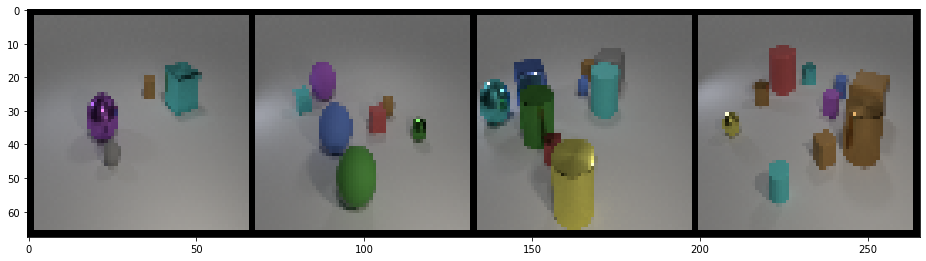

In [19]:
fig = plt.figure(figsize=(16, 10))
plt.imshow(T.functional.to_pil_image(make_grid(out_batch).cpu()))

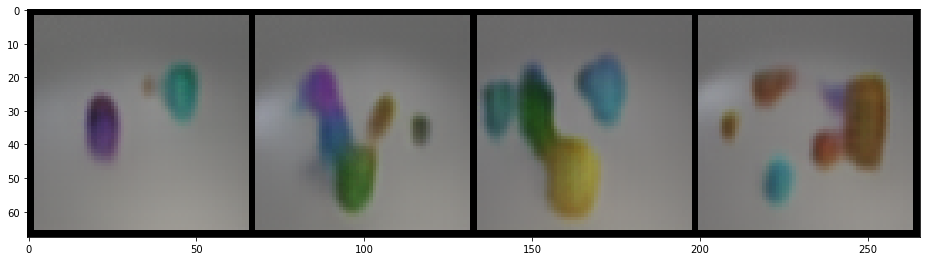

In [20]:
fig = plt.figure(figsize=(16, 10))
plt.imshow(T.functional.to_pil_image(make_grid(generated).cpu()))